In [1]:
from IPython.display import Image, display
import numpy as np
import os
from skimage.io import imread
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental import preprocessing

from keras.preprocessing import image

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
# Reconstruct the final model for prediction
model_path = '/content/drive/My Drive/_NOVA-IMS/2022_S2/Deep Learning/Project/model_EfficientNetB0_FineTuning'
model = keras.models.load_model(model_path)

# check the model architecture
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 1,022,613
Non-train

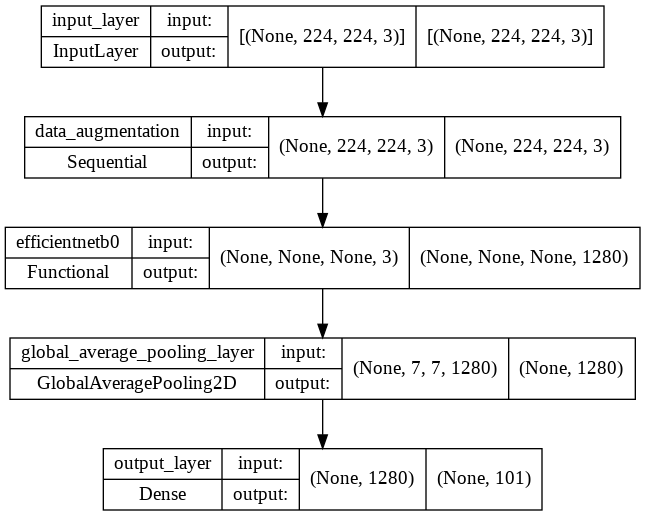

In [6]:
# graph of the summary of the model
plot_model(model, show_shapes=True)

In [7]:
# loading the pretrained model - EfficientNetB0 to apply the heatmap
base_model = tf.keras.applications.EfficientNetB0(weights='imagenet')

21848064/21834768 [==============================] - 0s 0us/step


In [8]:
# see the model architecture to select the final layer which will be applied on the heatmap
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0

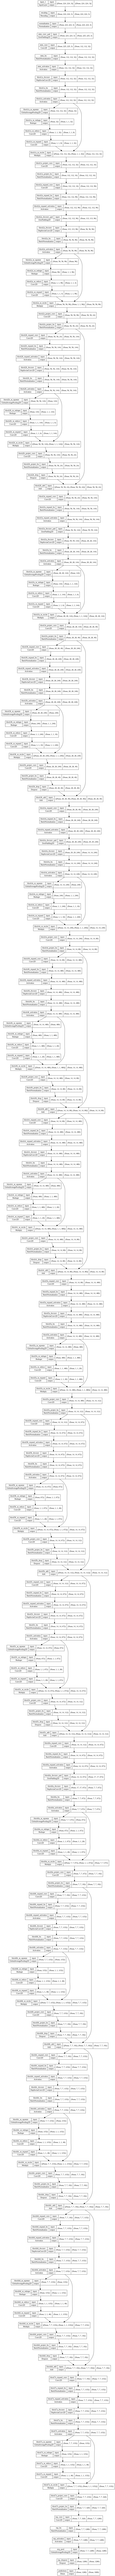

In [9]:
# graph of the summary of the base_model - EfficientNetB0
plot_model(base_model, show_shapes=True)

In [18]:
# The Grad-CAM algorithm - source: https://keras.io/examples/vision/grad_cam/

# function to get the image and transform it into an array
def get_img_array(img_path, size):
    # `img` is a PIL image of size 224x224
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (224, 224, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


# function to create the grad-cam heatmap
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


# function to overlap the heatmap and the real image
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))

In [11]:
# Define a list of all 101 classes sorted by name (alphabetic ascending) - this is the order of the number prediction
data_folder = '/content/drive/My Drive/_NOVA-IMS/2022_S2/Deep Learning/Project/images'

list_class = os.listdir(data_folder)
list_class.sort()

print(f'{len(list_class)} Classes of foods.')
print(list_class)

101 Classes of foods.
['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese',

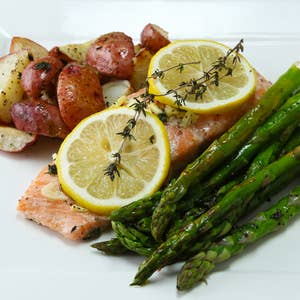

In [20]:
# Test in one image prediction

# The local path to our target image
img_path = '/content/drive/My Drive/_NOVA-IMS/2022_S2/Deep Learning/Project/allrecipes/Thumb_A.jpg'

# display the image with the training size
display(Image(filename=img_path, width=224, height=224))

Predicted class: grilled_salmon


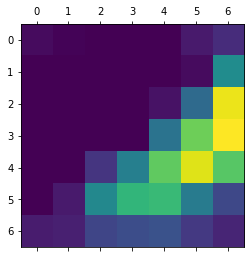

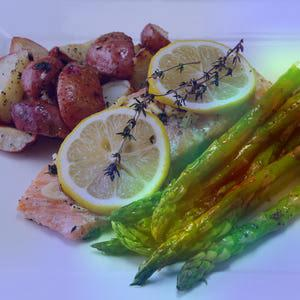

In [21]:
# Apply the Grad-CAM Algorithm

# prepare image
img_size = (224,224)
img_array = get_img_array(img_path, size=img_size)

# Print the predicted class
preds = model.predict(img_array)
print("Predicted class:", list_class[np.argmax(preds[0])])

# define the last CNN layer - name from base_model.summary() - EfficientNetB0 
last_conv_layer_name = 'top_conv'

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, base_model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

save_and_display_gradcam(img_path, heatmap)

101
Predicted: ravioli


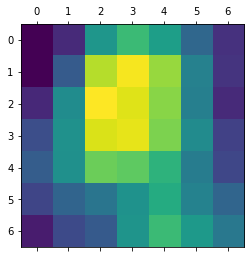

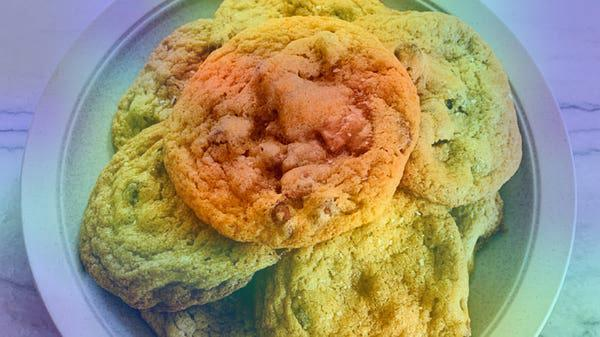

In [23]:
# Test in one image prediction

# The local path to our target image
img_path = '/content/drive/My Drive/_NOVA-IMS/2022_S2/Deep Learning/Project/allrecipes/6ec7eccca8734817b59c3e81f55bd2ee.jpeg'

# Prepare image
img_size = (224,224)
img_array = get_img_array(img_path, size=img_size)

# Print what the top predicted class is
preds = model.predict(img_array)
print(len(preds[0]))
print("Predicted:", list_class[np.argmax(preds[0])])

# name form model.summary() of the last CNN layer
last_conv_layer_name = 'top_conv'

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, base_model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

save_and_display_gradcam(img_path, heatmap)

101
Predicted: macarons


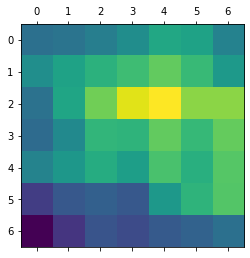

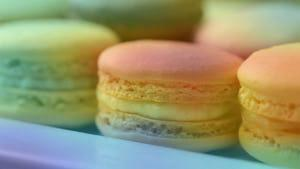

In [22]:
# Test in one image prediction

# The local path to our target image
img_path = '/content/drive/My Drive/_NOVA-IMS/2022_S2/Deep Learning/Project/allrecipes/BFV37854_TheMostFoolProofMacaronsYoullEverMake_KP_121819_YT.jpg'

# Prepare image
img_size = (224,224)
img_array = get_img_array(img_path, size=img_size)

# Print what the top predicted class is
preds = model.predict(img_array)
print(len(preds[0]))
print("Predicted:", list_class[np.argmax(preds[0])])

# name form model.summary() of the last CNN layer
last_conv_layer_name = 'top_conv'

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, base_model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

save_and_display_gradcam(img_path, heatmap)

101
Predicted: donuts


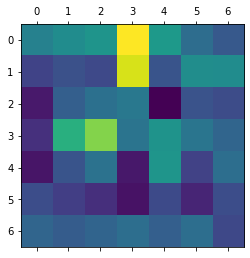

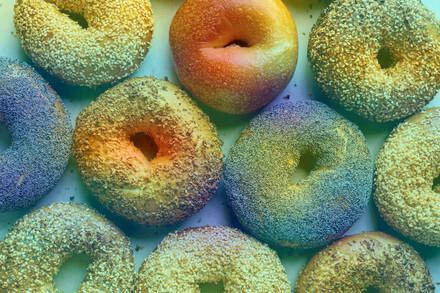

In [24]:
# Test in one image prediction

# The local path to our target image
img_path = '/content/drive/My Drive/_NOVA-IMS/2022_S2/Deep Learning/Project/allrecipes/13Bagels-a-mediumThreeByTwo440-v2.jpg'

# Prepare image
img_size = (224,224)
img_array = get_img_array(img_path, size=img_size)

# Print what the top predicted class is
preds = model.predict(img_array)
print(len(preds[0]))
print("Predicted:", list_class[np.argmax(preds[0])])

# name form model.summary() of the last CNN layer
last_conv_layer_name = 'top_conv'

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, base_model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

save_and_display_gradcam(img_path, heatmap)